# Tutorial: How to Create Workflows with RFlow

This tutorial shows how the RFlow module can help to develop scientific-computational experiments.

Consider the hypothetical routine of computing the frequency of words from a text file. It is a simplification of a typical stage in machine learning, natural language processing, or even bioinformatics. Although simple, it summarizes two practical problems addressed by researchers:

* How to reproduce and share experiments.
* How to do experiments based on interchangeable parts.

In this example, the first step taken by many developers would to start with the main logic for counting:

In [1]:
def compute_word_freq(input_filepath):
    """Compute word frequency from a input text file.
    
    Args:
        input_filepath (str): Input text file path.
           
    Returns:
        Dict[str: int]: Each key is a word, and its 
         values are their frequency.
    """

    word_freq = {}

    # Count the words
    with open(input_filepath, 'r') as stream:
        for line in stream:
            for word in line.split():
                word_freq[word] = word_freq.get(word, 0) + 1

    return word_freq

The above function returns a dictionary with the count of every word. It's run as follows on the `big-text.txt` text file:

In [2]:
word_freq = compute_word_freq('big-text.txt')

An essential part of any experimentation is visualizing stage results. A researcher could write the following code to show the `K` most frequent words:

In [3]:
def print_kmost(word_freq, K=5):
    """Prints the K most frequent words.
    
    Args:
        word_freq (Dict[str: int]): Each key is a word, 
         and its values are its counting.
        K (int): Specify how many words to show.
    """

    ordered_words = sorted(word_freq.items(),
                           key=lambda item: item[1],
                           reverse=True)
    for i, (word, count) in enumerate(ordered_words):
        if i == K:
            break
        print('{}-nth word: "{}" happens {} times'.format(
              i, word, count))


Then the complete code of this small experiment becomes:

In [4]:
%%time
word_freq = compute_word_freq('big-text.txt')
print_kmost(word_freq, K=10)

0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
CPU times: user 434 ms, sys: 12.1 ms, total: 446 ms
Wall time: 445 ms


Actual experiments, as typically found in Deep Learning or Big-data, may take hours or days.

In order not to perform processing unnecessarily, a common strategy is to leave the experiment reentrant. That is, saving intermediate results in files, and load them in future executions.

Continuing with this idea, routines to save and load data can be like this:

In [5]:
def save_freq(word_freq, output_filepath):    
    with open(output_filepath, 'w') as stream:
        for word, cont in word_freq.items():
            stream.write('{} {}\n'.format(word, cont))
            
def load_freq(input_filepath):
    with open(input_filepath, 'r') as stream:
        word_freq = {}
        for line in stream:
            word, cont = line.split()
            word_freq[word] = int(cont)
    return word_freq

The naive way of joining the steps is to check for the existence of the generated files manually:

In [6]:
import os

def exp1():
    if not os.path.exists("big-text-freq.txt"):
        word_freq = compute_word_freq("big-text.txt")
        save_freq(word_freq, "big-text-freq.txt")
    else:
        word_freq = load_freq("big-text-freq.txt")

    print_kmost(word_freq, 10)

In [7]:
# For demonstration pruposes, assure that 
# the frequency file doesn't exists.
import os

if os.path.exists('big-text-freq.txt'):
    os.remove('big-text-freq.txt')

In [8]:
%%time
exp1()

0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
CPU times: user 481 ms, sys: 16.4 ms, total: 497 ms
Wall time: 489 ms


Now rerunning the experiment, the processing time will undergo a drastic reduction:

In [9]:
%%time
exp1()

0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
CPU times: user 87.2 ms, sys: 12 ms, total: 99.2 ms
Wall time: 95.8 ms


Note that reading the results of a file was at least 2 times faster than re-computing again.

However, actual experiments contain multiple stages, and it would not be productive to repeat the reentrant logic code every time. More importantly, if parameters changes, then the affected parts or dependencies need to be rerun. For example, `compute_word_freq` stage depends on the data of 'big.txt'. Dependency means that if the file "big.txt" is modified, then the count must be (re)done even if its intermediary exists.

Tools like Make, Luigi, Weka, and our RFlow, encapsulate this check by modeling experiment as a direct acyclic graph (DAG). With experiments being viewed as graphs, the computations and data become the nodes, and their dependencies become the edges.

RFlow also represents experiments as DAG. We'll start a graph with RFlow; then we'll define a node for computing word frequencies, and add it to the DAG. 

One way to get a DAG object is to call `rflow.get_graph`:

In [10]:
import rflow
exp1 = rflow.get_graph('exp1')

This will create a DAG named `'exp1'`. On RFlow, any DAG can be retrieved from the `get_graph` function.

To define nodes, users should inherit from the class `rflow.Interface`. The derived classes must implement a `evaluate()` function, and a optional `load()`. The first one is where the main logic should put, and save its intermediary results. The second one, `load()`, should keep the node reentrant, by loading the previously computed value. 

The node type `WordFrequency` will carry previous word frequency functionality of computing and load:

In [11]:
class WordFrequency(rflow.Interface):
    """Compute word frequencies from a input text file.
    """

    def evaluate(self, resource, input_resource):
        """Args:

            resource (skrkit.workflow.FSResource): Reentrancy checkpoint. 

            input_resource (skrkit.workflow.FSResource): Resource pointing to 
                the input text file path.
             
        Returns:
            Dict[str: int]: Each key is a word, and values are its
             counting.
        """
        
        word_freq = compute_word_freq(input_resource.filepath)        
        save_freq(word_freq, resource.filepath)
        return word_freq

    def load(self, resource):
        """Loads the data from previous `evaluate()` call.

        Args:
            resource (skrkit.workflow.FSResource): Reentrancy checkpoint. 

        Returns:
            Dict[str: int]: Each key is a word, and values are its
             counting.
        """

        return load_freq(resource.filepath)


The above code needs some clarications.
    
As early stated, RFlow can track changes of nodes inputs. To track changes that occur inside external entities such files or database entry, RFlow provides classes derived from `rflow.Resource` which encapsulates existence testing and content representation. 

The `evaluate()` function, calls the main logic and save the results. Node's `evaluate()` function may take any number of arguments. In the above case, it accepts two arguments: `resource` and `input_resource`. The `resource` name is a special one for RFlow. Arguments named as this are expected to be a `Resource` type. It tells to RFlow that the node is reentrant, and its value must refer to an intermediary checkpoint destination. The code refers to a `filepath` attribute, meaning that `WordFrequency` expects a file system resource - a `rflow.FSResource` instance.

The second argument is also expected to be a `rflow.FSResource`. So RFlow will detect changes on the file content, and rerun the `evaluate()` if they occur.

The `load()` function is called whatever RFlow judges that no alteration occurred to the node's inputs. So it can be loaded.

Until now, only the node definition were shown. To put the class into use, it must be instantiated and added to a DAG:

In [12]:
exp1.word_freq = WordFrequency(rflow.FSResource('big-text-freq.txt'))

A node is added by instancing and assigning it to a DAG attribute. For those not familiar with Python, new attributes can be added to an object on the fly. Every instanced node have a unique name given by its attribute name, as `word_freq` in the previous line. This name can be referenced to invoke it from command-line.

The constructor argument, `rflow.FSResource('big-text-freq.txt')`, is the `resource` argument value. The `resource` parameter is so special that it be can passed directly on the constructor. Following its node definition, it's a file system resource.

Other arguments are assigned to nodes by using its `.args` attribute. By reflection, RFlow fills `.args` with attributes named after each  `evaluate()` arguments. For example, to set `input_resource` pointing to the 'big-text.txt' file system resource:

In [13]:
exp1.word_freq.args.input_resource = rflow.FSResource('big-text.txt')

To execute any node, invoke its `call()` method instead of `evaluate()` or `load()`. This function will verify the reentracy conditions, and use the appropiate method:

In [14]:
word_freq = exp1.word_freq.call()

RUN  exp1:word_freq
^exp1:word_freq


The `call()` method returns the same as `evaluate()` (or `load()`). 

Let's keep building the rest of the experiment, now by defining a node to show words.

In [15]:
class PrintKMost(rflow.Interface):
    """Prints the K most frequent words.    
    """

    def evaluate(self, word_freq, K):   
        """Args:
        word_freq (Dict[str: int]): Each key is a word, 
         and its values are their frequency.
         
        K (int): Specify how many words to show.
        """ 

        ordered_words = sorted(word_freq.items(),
                               key=lambda item: item[1],
                               reverse=True)
        for i, (word, count) in enumerate(ordered_words):
            if i == K:
                break
            print('{}-nth word: "{}" happens {} times'.format(
                  i, word, count))

The `PrintKMost` node is a simpler one. As it doesn't produce any intermediary results, so no do need to have a `resource` argument. Differently from the `WordFrequency`, it accepts common python object like the `word_freq` dict or the `K` integer.  

Adding to the graph:

In [16]:
exp1.kmost_freq = PrintKMost()
with exp1.kmost_freq as args:    
    args.word_freq = exp1.word_freq
    args.K = 10

As a shortcut to `args` attribute, users may use the `with` statement to not repeat the `graph.vertice.args.` pattern. 

When setting `args.word_freq = exp1.word_freq` argument, we create a edge from the `exp1.word_freq` node to `exp1.kmost_freq`.  The return value of `exp1.word_freq` will be send to the `word_freq` argument of `kmost_freq`. The `K` argument was set to a constant value.

Like for `word_freq`, the `kmost_freq` is executed with `call()`. Besides checking reentrancy, the call method resolves dependency call, executing only the need nodes.

In [17]:
exp1.kmost_freq.call()

RUN  exp1:kmost_freq
0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
^exp1:kmost_freq


In that call, `exp1.word_freq` was evaluated. The next example will clean the middle node, and rerun:

In [18]:
exp1.word_freq.clear()
exp1.kmost_freq.call()

Removing resource big-text-freq.txt
RUN  exp1:kmost_freq
.RUN  exp1:word_freq
.^exp1:word_freq
0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
^exp1:kmost_freq


Executing it again:

In [19]:
# RFlow caches previous values. 
# Use `redo=True` to force the call
# node execution
exp1.kmost_freq.call(redo=True)

RUN  exp1:kmost_freq
0-nth word: "the" happens 71744 times
1-nth word: "of" happens 39169 times
2-nth word: "and" happens 35968 times
3-nth word: "to" happens 27895 times
4-nth word: "a" happens 19811 times
5-nth word: "in" happens 19515 times
6-nth word: "that" happens 11216 times
7-nth word: "was" happens 11129 times
8-nth word: "his" happens 9561 times
9-nth word: "he" happens 9362 times
^exp1:kmost_freq


### The `.args` value restrictions

RFlow writes all arguments to a database, so every node instance has a signature of its previous call. If the signature matches with the stored one, the node is considered updated. However, constant values such `kmost_freq.args.K = 10` must have two restrictions:

* Must be serializable with `pickle`;
* Must have a `__equal__` implementation.

Those two restrictions are needed to compare and write the signatures. Suppose that we're using the following `Uncomparable` class, that does not have a `__eq__` method:


In [20]:
class Uncomparable:
    def __init__(self, a):
        self.a = a

    def __str__(self):
        return str(self.a)                

Uncomparable objects happens mostly with C/C++ wrappers or too big to compare objects. If we try to add to the following DAG:

In [21]:
class Print(rflow.Interface):
    def evaluate(self, obj):
        print(obj)
        
ta = rflow.get_graph('test-args', overwrite=True)
ta.print_const = Print()
try:
    ta.print_const.args.obj = Uncomparable(4)
except rflow.WorkflowError as error:
    print("Error: {}".format(error))

Error: Assigning a non equalable value that is not derived from BaseNode or Resource


An error is raised because `Uncomparable` does not have a `__eq__` override. 

To actually add it to a graph is necessary to encapsulate inside a node, so RFlow can compare its signature. 

One way is to use the `rflow.VarNode` class:

In [22]:
ta.print_const.args.obj = rflow.VarNode(Uncomparable(4))

As a downside,  `Uncomparable` will always be created. To overcome this, we can create a node to initialize it:

In [23]:
class GetUncomparable(rflow.Interface):
    def evaluate(self, int_value):
        return Uncomparable(int_value)
    
ta.get_uncomp = GetUncomparable()
ta.get_uncomp.args.int_value = 4

ta.print_const.args.obj = ta.get_uncomp

In [24]:
ta.print_const.call()

RUN  test-args:print_const
.RUN  test-args:get_uncomp
.^test-args:get_uncomp
4
^test-args:print_const


The later way advantage is that the construction arguments are tracked.

## Viewing Graphs

RFlow graphs can be view with Graphviz:

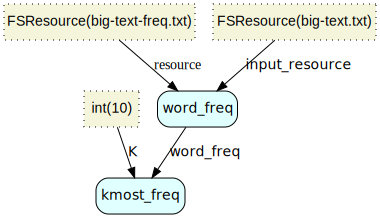

In [25]:
import graphviz
import rflow.viz as viz

viz.dag2dot(exp1)

## Adding more nodes

Suppose that a new thesis arrived about random texting counting. Researchers want to base their new experiments on the former base, so they know that are using the same procedures on both thesis.

With RFlow, they could define a new graph vertex for generating random text and insert into a new graph.

First, the next code will define the random text generator interface:

In [26]:
import random

class RandomText(rflow.Interface):
    """Generates random text.
    """

    def evaluate(self, resource, num_of_words, selected_words):
        """Args:

            resource (rflow.FSResource): File resource to 
             write the random words.

            num_of_words (int): How many words to generate.

            selected_words (List[str]): Which words to use.
        """

        with open(resource.filepath, 'w') as file_stream:
            for i in range(num_of_words):
                random_word = random.sample(selected_words, 1)[0]
                file_stream.write(random_word)
                file_stream.write(' ')

    def load(self):
        """The `load()` method indicates to RFlow that node is reentrant. 
        As `evaluate()` didn't return anything, we can leave it empty.        
        """
        pass


Next step will be creating a new graph named `exp2` to hold our new experiment.

In [27]:
exp2 = rflow.get_graph('exp2', overwrite=True)    

The `RandomText` is instantiated with the name `random_text`. It will generate the resource `'random-text.txt'`:

In [28]:
exp2.random_text = RandomText(rflow.FSResource('random-text.txt'))

According to logic of the interface, it accepts `num_of_words` as how many words to generate, and `selected_words` as which words to use. Let generate 50 words with the classic "lorem ipsum" text. The `with` shortcut will be used to set the `exp2.random_text.args` attributes:

In [29]:
with exp2.random_text as args:
    args.num_of_words = 50
    args.selected_words = [
            'lorem', 'ipsum', 'dolor', 'sit', 'amet',
            'consectetur', 'adipiscing', 'elit', 'vestibulum',
            'non', 'feugiat', 'felis']


Let connect the `random_text` node to a `WordFrequency` instance.

In [30]:
exp2.word_freq = WordFrequency(rflow.FSResource('random-text-freq.txt'))
exp2.word_freq.args.input_resource = exp2.random_text.resource

In exp1, `word_freq` was direct assigned to `kmost_freq.args.word_freq`. In the above code, the assignment is between resource to another resource. Assigning a node's `.resource` is a special case which also generates dependency between nodes.

Now reusing the `PrintKMost` viewing node:

In [31]:
exp2.kmost_freq = PrintKMost()
with exp2.kmost_freq as args:    
    args.word_freq = exp2.word_freq
    args.K = 10

The final DAG becomes:

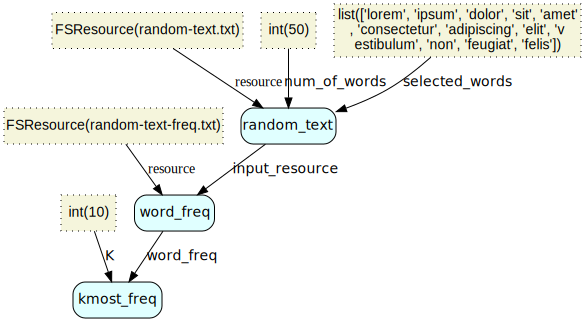

In [32]:
viz.dag2dot(exp2)

Executing it two times to check whatever RFlow not execute `random_text` or `word_freq` without necessity.

In [33]:
exp2.random_text.clear() # Remove previous run random text

exp2.kmost_freq.call()

Removing resource random-text.txt
RUN  exp2:kmost_freq
.RUN  exp2:word_freq
..RUN  exp2:random_text
..^exp2:random_text
.^exp2:word_freq
0-nth word: "dolor" happens 10 times
1-nth word: "consectetur" happens 7 times
2-nth word: "amet" happens 7 times
3-nth word: "ipsum" happens 5 times
4-nth word: "lorem" happens 4 times
5-nth word: "sit" happens 3 times
6-nth word: "feugiat" happens 3 times
7-nth word: "non" happens 3 times
8-nth word: "vestibulum" happens 2 times
9-nth word: "adipiscing" happens 2 times
^exp2:kmost_freq


First time executed as expected, running all the DAG.

In [34]:
# Use the redo flag again, to force
# kmost_freq execution.
exp2.kmost_freq.call(redo=True)

RUN  exp2:kmost_freq
0-nth word: "dolor" happens 10 times
1-nth word: "consectetur" happens 7 times
2-nth word: "amet" happens 7 times
3-nth word: "ipsum" happens 5 times
4-nth word: "lorem" happens 4 times
5-nth word: "sit" happens 3 times
6-nth word: "feugiat" happens 3 times
7-nth word: "non" happens 3 times
8-nth word: "vestibulum" happens 2 times
9-nth word: "adipiscing" happens 2 times
^exp2:kmost_freq


As expected, the system didn't evaluate two times `random_text` or `word_freq`, just `kmost_freq`.

For testing raw python values changes, the next code modifies the random generator parameter to make 100 words:

In [35]:
exp2.random_text.args.num_of_words = 100
exp2.kmost_freq.call(redo=True)

RUN  exp2:kmost_freq
.RUN  exp2:word_freq
..RUN  exp2:random_text
..^exp2:random_text
.^exp2:word_freq
0-nth word: "lorem" happens 11 times
1-nth word: "vestibulum" happens 10 times
2-nth word: "elit" happens 10 times
3-nth word: "amet" happens 10 times
4-nth word: "dolor" happens 10 times
5-nth word: "felis" happens 10 times
6-nth word: "adipiscing" happens 8 times
7-nth word: "ipsum" happens 8 times
8-nth word: "non" happens 7 times
9-nth word: "feugiat" happens 6 times
^exp2:kmost_freq


When changing `num_of_words` to 100, RFlow detected this and recalled all dependent nodes.

## Putting DAG inside workflow.py files

RFlow DAG can be used inside Jupyter notebooks, but it is primarily designed to run from files named `workflow.py`. This makes more comfortable sharing and reusing code. 

For the word counting example, create the file [workflow.py](workflow.py) in the same directory as the "big.txt" file.  Put all node definition code in it.
 
The graph code will be the same, except that it should use the `rflow.graph()` decorator to provide an initialized graph object. The next snippet shows how the graph code should be placed on the file:

```python
@rflow.graph()
def exp2(g):
    g.random_text = RandomText(rflow.FSResource('random-text.txt'))
    with g.random_text as args:
        args.num_of_words = 50
        args.selected_words = [
            'lorem', 'ipsum', 'dolor', 'sit', 'amet',
            'consectetur', 'adipiscing', 'elit', 'vestibulum',
            'non', 'feugiat', 'felis']

    g.word_freq = WordFrequency(rflow.FSResource('random-text-freq.txt'))
    g.word_freq.args.input_resource = g.random_text.resource

    g.kmost_freq = PrintKMost()
    with g.kmost_freq as args:    
        args.word_freq = g.word_freq
        args.K = 10
```

On the above code: 

* The graph's name is its function name - `exp2`.
* The `g` variable is a already created graph by the decorator.

Graphs then can be executed with `rflow` command. The first one will `clean` the `word_freq` node:

In [36]:
!rflow exp2 clean word_freq

Removing resource random-text-freq.txt


The first argument to `rflow` is the target graph. The second one is the command. There are the following commands:

In [37]:
!rflow exp2 -h

usage: rflow [-h] {exp2} {run,touch,print-run,viz-dag,help,clean}

Shrkit workflow manager

positional arguments:
  {exp2}
  {run,touch,print-run,viz-dag,help,clean}

optional arguments:
  -h, --help            show this help message and exit


The `run` command executes a given node. Use the  `-h` flag to show the available nodes:

In [38]:
!rflow exp2 run -h

usage: rflow [-h] [--redo] node

Executes the workflow to a node.

positional arguments:
  node        random_text, word_freq, kmost_freq

optional arguments:
  -h, --help  show this help message and exit
  --redo, -r  Redo the last node, whatever even if it's updated (default:
              False)


To run the `kmost_freq` from command-line:

In [39]:
!rflow exp2 run kmost_freq

RUN  exp2:kmost_freq
.RUN  exp2:word_freq
..RUN  exp2:random_text
..^exp2:random_text
.^exp2:word_freq
0-nth word: "amet" happens 7 times
1-nth word: "non" happens 7 times
2-nth word: "lorem" happens 6 times
3-nth word: "elit" happens 5 times
4-nth word: "dolor" happens 5 times
5-nth word: "consectetur" happens 5 times
6-nth word: "vestibulum" happens 4 times
7-nth word: "felis" happens 4 times
8-nth word: "sit" happens 3 times
9-nth word: "adipiscing" happens 2 times
^exp2:kmost_freq


Testing again should not evaluate `word_freq` again.

In [40]:
!rflow exp2 run kmost_freq

RUN  exp2:kmost_freq
.LOAD exp2:word_freq
.^DONE exp2:word_freq
0-nth word: "amet" happens 7 times
1-nth word: "non" happens 7 times
2-nth word: "lorem" happens 6 times
3-nth word: "elit" happens 5 times
4-nth word: "dolor" happens 5 times
5-nth word: "consectetur" happens 5 times
6-nth word: "vestibulum" happens 4 times
7-nth word: "felis" happens 4 times
8-nth word: "sit" happens 3 times
9-nth word: "adipiscing" happens 2 times
^exp2:kmost_freq


Graphviz visualizations are available on command line too:

```shell
$rflow exp2 viz-dag
```

## Using sub-graphs

Sometimes researchers want to keep two parameterized branches of an experiment. In RFlow they can create sub-functions to generate on the fly.

Suppose that we want to track the effects of counting 50 or 100 random words. Next code creates a function to generate DAGs with different word counts, through `word_count` parameter.

In [41]:
def _sub_graph(s, word_count):
    s.random_text = RandomText(rflow.FSResource('{}-random-text.txt'.format(word_count)))
    with s.random_text as args:
        args.num_of_words = word_count
        args.selected_words = [
            'lorem', 'ipsum', 'dolor', 'sit', 'amet',
            'consectetur', 'adipiscing', 'elit', 'vestibulum',
            'non', 'feugiat', 'felis']

    s.word_freq = WordFrequency(rflow.FSResource('{}-random-text-freq.txt'.format(word_count)))
    s.word_freq.args.input_resource = s.random_text.resource

    s.kmost_freq = PrintKMost()
    with s.kmost_freq as args:    
        args.word_freq = s.word_freq
        args.K = 10
        

**Note:** The resource file paths were set to reflect their corresponding parameters. 

There are two ways to use `_sub_graph`. The first is by creating a new graph:

In [42]:
exp2_50 = rflow.get_graph('exp2_50', overwrite=True)
exp2_100 = rflow.get_graph('exp2_100', overwrite=True)

_sub_graph(exp2_50, 50)
_sub_graph(exp2_100, 100)

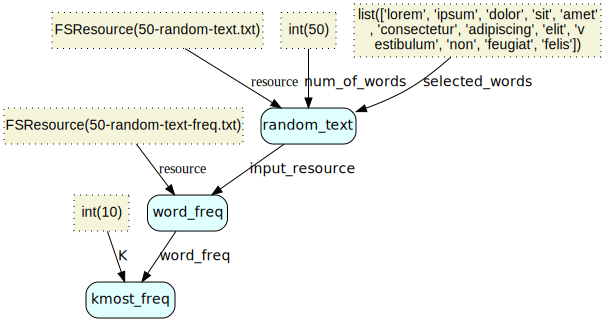

In [43]:
viz.dag2dot(exp2_50)

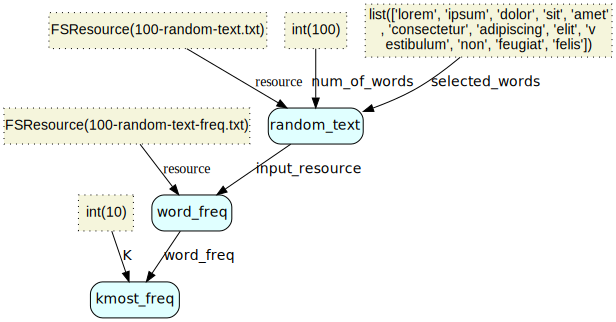

In [46]:
viz.dag2dot(exp2_100)

Alternatively, they can just be put in the same graph, but with different vertex names. The `prefix()` method returns a temporally graph, where each node has it name prefixed with the prefix string.  

The following example creates a graph to hold 50 and 100 graphs. Each one prefixed with, respectively, `n50` and `n100` strings.

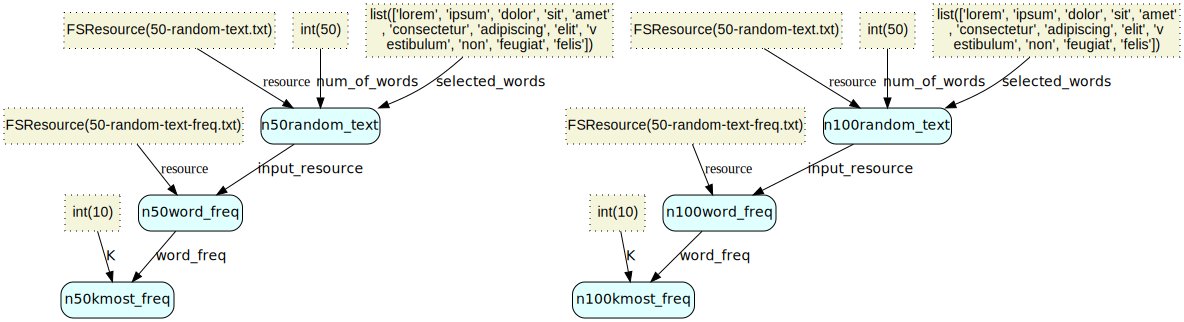

In [45]:
exp2_50_100 = rflow.get_graph('exp2_50_100', overwrite=True)

_sub_graph(exp2_50_100.prefix('n50'), 50)
_sub_graph(exp2_50_100.prefix('n100'), 50)
viz.dag2dot(exp2_50_100)